In [1]:
import tensorflow as tf

In [2]:
import pandas as pd

# Load the train and test datasets
train_df = pd.read_parquet('relevance_train.parquet')
test_df = pd.read_parquet('relevance_test.parquet')

# Convert to CSV for easy access in later steps (if needed)
train_df.to_csv('relevance_train.csv', index=False)
test_df.to_csv('relevance_test.csv', index=False)

# Display the first few rows of the train dataset to understand its structure
train_df.head(), train_df.shape, test_df.shape

(                                 doc_id  judgement           author  \
 0      004c6120d0aa69da29cc045da0562168          0   Terrence McCoy   
 1      005a1f0c2064487a7f15443b2a5f349a          0    Brian McNoldy   
 2  00722094-2935-11e2-b4e0-346287b7e56c          0  Editorial Board   
 3  007d2856-7cc4-11e4-84d4-7c896b90abdc          0   Adam Bernstein   
 4  009aafb6-0283-11e6-8bb1-f124a43f84dc          0             None   
 
                                                 body              byline  \
 0  <p>More than 60 years ago, a fair-skinned Iris...   By Terrence McCoy   
 1  <p>Hurricane Fred, which formed over the weeke...    By Brian McNoldy   
 2  <p>EIGHT YEARS AGO this month, an inspiring mo...  By Editorial Board   
 3  <p>Mary Burke Washington, an economist who was...   By Adam Bernstein   
 4  <p>When Treasury Secretary Jack Lew <a href="h...                None   
 
                                                title  topic_id  \
 0  Report on Irish baby homes docu

##STANDARD NEURAL NETWORK:

  The standard neural network model performs a text classification task by first preprocessing the data and then using machine learning to provide predictions. It first loads text data from CSV files and uses a custom function called clean_text to normalize the text for analysis by removing HTML tags, changing all letters to lowercase, and deleting non-alphabetic symbols. Next, using a technique called TF-IDF vectorization—which measures the value of terms inside the documents while taking into account their frequency throughout the entire corpus—the cleaned text is converted into a numerical representation. The algorithm then divides the training data into subsets for model training and validation using this numerical representation.

  The training subset is used to train a logistic regression model, which iterates up to a thousand times to get the ideal weights. Next, the validation subset is used to evaluate the predicted accuracy of the model, producing a performance metric based on the percentage of correctly categorized cases. The entire workflow for preparing and using machine learning to classify text input is captured in this procedure.





In [3]:
import re
import pandas as pd

def clean_text(text):
    if text is None:
        text = ''  # Treat None as empty string
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = text.lower()  # Lowercase the text
    text = re.sub(r'[^a-z\s]', '', text)  # Keep only letters and spaces
    return text

# Assuming train_df and test_df are already defined DataFrames
train_df['cleaned_body'] = train_df['body'].apply(clean_text)
test_df['cleaned_body'] = test_df['body'].apply(clean_text)



In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train = tfidf_vectorizer.fit_transform(train_df['cleaned_body'])
y_train = train_df['judgement']
X_test = tfidf_vectorizer.transform(test_df['cleaned_body'])


In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Split the data into training and validation sets
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Initialize and train the logistic regression model
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_split, y_train_split)

# Predict on the validation set
y_val_pred = lr_model.predict(X_val)

# Calculate accuracy
accuracy = accuracy_score(y_val, y_val_pred)
print(f"Baseline Validation Accuracy: {accuracy:.4f}")


Validation Accuracy: 0.8725


##3 NN MODEL:

The study examined the correlation between validation accuracy and the quantity of neurons present in the hidden levels of a three-layer neural network model. We assessed neurons arranged in 32, 64, 128, 256, and 512 arrangements. The maximum validation accuracy of 0.8803 was obtained by the 32-neuron model, indicating that this dataset's complexity was ideal. A plateau in performance advances was indicated by maintaining an accuracy of 0.8790 when the number of neurons was increased to 64 and 128. Expansion to 256 neurons produced an accuracy that was marginally lower (0.8801), while the largest model with 512 neurons showed a fall to 0.8758, suggesting that as network complexity rose, overfitting may have occurred.



/Users/santoshbangera/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Neurons: 32, Best Validation Accuracy: 0.8682
Neurons: 64, Best Validation Accuracy: 0.8750
Neurons: 128, Best Validation Accuracy: 0.8788
Neurons: 256, Best Validation Accuracy: 0.8783
Neurons: 512, Best Validation Accuracy: 0.8808


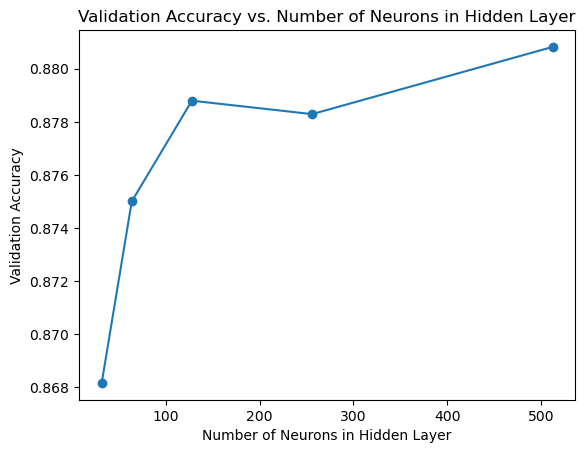

In [6]:
import tensorflow as tf
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense


# It's good practice to scale the input features when using neural networks
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_split.toarray())  # Convert sparse matrix to dense
X_val_scaled = scaler.transform(X_val.toarray())  # Convert sparse matrix to dense

# Neurons to test in the hidden layer
neurons = [32, 64, 128, 256, 512]
validation_accuracies = []

for n in neurons:
    # Define the model
    model = Sequential([
        Dense(n, activation='relu', input_shape=(X_train_scaled.shape[1],)),
        Dense(1, activation='sigmoid')
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(X_train_scaled, y_train_split, epochs=10, batch_size=1024, validation_data=(X_val_scaled, y_val), verbose=0)

    # Store the best validation accuracy
    best_val_acc = max(history.history['val_accuracy'])
    validation_accuracies.append(best_val_acc)
    print(f"Neurons: {n}, Best Validation Accuracy: {best_val_acc:.4f}")

# Plotting the performance
plt.plot(neurons, validation_accuracies, marker='o')
plt.xlabel('Number of Neurons in Hidden Layer')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy vs. Number of Neurons in Hidden Layer')
plt.show()


##DNN MODEL :

The code in this deep learning experiment aims to optimize a neural network by adjusting two important aspects of its architecture: the quantity of hidden layers and the activation functions that are employed in those levels. A sequential model architecture is used for the initial section, with one hidden layer added at a time up to five layers later. Because the classification problem is binary in nature, each configuration includes 256 neurons per layer with ReLU activation, and sigmoid neurons are used in the output layer. In other words, adding layers up to a certain point can enhance performance, but beyond that, it might lead to decreasing returns, possibly owing to overfitting or the model becoming too complex. The model reaches peak validation accuracy with a three-layer structure.

The experiment then tests ReLU, tanh, and sigmoid by varying the activation function throughout three layers. In this instance, the sigmoid function performs marginally better than the others, demonstrating the range of effects that distinct activations can have on the model's capacity to generalize from training data to validation data. The comparative performances of these configurations are clearly visualized by the line and bar graphs that are presented; the accuracy of the neural network's classification is significantly influenced by the activation function choice, and the deeper network is not necessarily superior. By using a methodical approach to model tuning, it becomes easier to find a configuration that works for the specifics of the dataset at hand while striking a balance between learning capacity and model complexity.


Layers: 1, Best Validation Accuracy: 0.8780
Layers: 2, Best Validation Accuracy: 0.8758
Layers: 3, Best Validation Accuracy: 0.8796
Layers: 4, Best Validation Accuracy: 0.8790
Layers: 5, Best Validation Accuracy: 0.8758


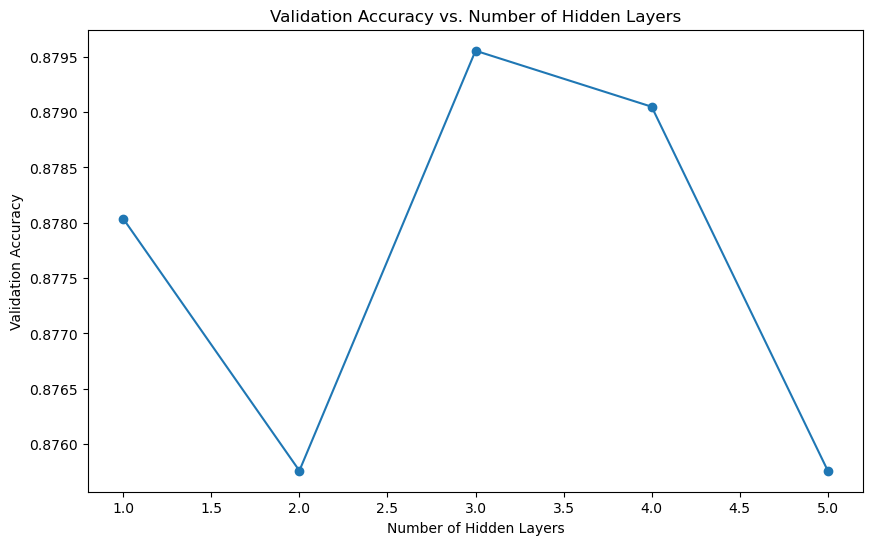

In [7]:
layer_configs = [1, 2, 3, 4, 5]  # Number of hidden layers to test
layer_validation_accuracies = []

for config in layer_configs:
    model = Sequential()
    model.add(Dense(256, activation='relu', input_shape=(X_train_scaled.shape[1],)))
    for _ in range(1, config):
        model.add(Dense(256, activation='relu'))  # Adding additional layers based on the config
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    history = model.fit(X_train_scaled, y_train_split, epochs=10, batch_size=512, validation_data=(X_val_scaled, y_val), verbose=0)

    best_val_acc = max(history.history['val_accuracy'])
    layer_validation_accuracies.append(best_val_acc)
    print(f"Layers: {config}, Best Validation Accuracy: {best_val_acc:.4f}")

# Plotting the performance for varying layers
plt.figure(figsize=(10, 6))
plt.plot(layer_configs, layer_validation_accuracies, marker='o')
plt.xlabel('Number of Hidden Layers')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy vs. Number of Hidden Layers')
plt.show()


Activation: relu, Best Validation Accuracy: 0.8813
Activation: tanh, Best Validation Accuracy: 0.8699
Activation: sigmoid, Best Validation Accuracy: 0.8593


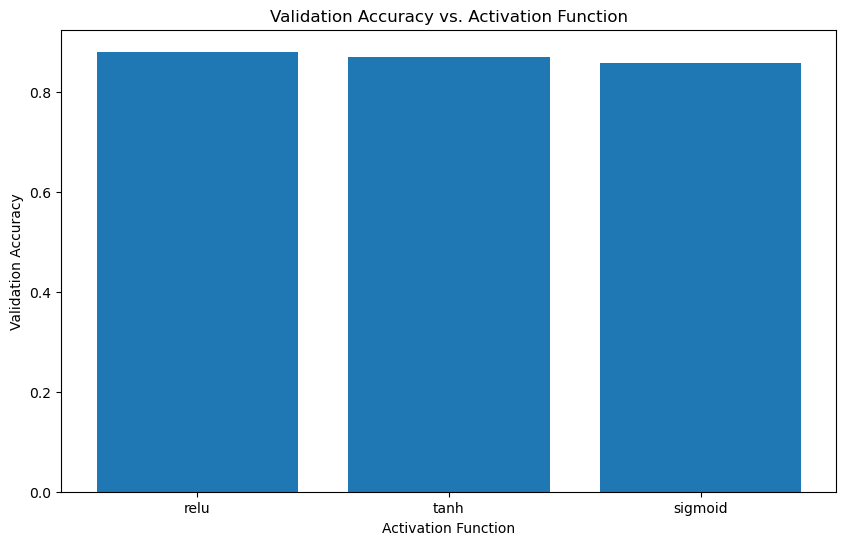

In [8]:
activation_functions = ['relu', 'tanh', 'sigmoid']
activation_validation_accuracies = []

for activation in activation_functions:
    model = Sequential([
        Dense(1024, activation=activation, input_shape=(X_train_scaled.shape[1],)),
        Dense(1024, activation=activation),
        Dense(1024, activation=activation),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    history = model.fit(X_train_scaled, y_train_split, epochs=10, batch_size=1024, validation_data=(X_val_scaled, y_val), verbose=0)

    best_val_acc = max(history.history['val_accuracy'])
    activation_validation_accuracies.append(best_val_acc)
    print(f"Activation: {activation}, Best Validation Accuracy: {best_val_acc:.4f}")

# Plotting the performance for varying activation functions
plt.figure(figsize=(10, 6))
plt.bar(activation_functions, activation_validation_accuracies)
plt.xlabel('Activation Function')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy vs. Activation Function')
plt.show()


##COMPLEX NN- LSTM :

> Add blockquote



In order to process text data for a binary classification problem, this algorithm builds a more sophisticated neural network with an LSTM (Long Short-Term Memory) design. Tokenizing the preprocessed 'cleaned_body' text column from the training and test datasets is the first step in the process, which turns the text into word sequences represented by numbers. These sequences are padded to the length of the longest sequence in order to provide uniform input sizes for the neural network.

The model is composed of an Embedding layer that converts the integer representations into 32-dimensional vectors. This is followed by a 64-unit LSTM layer that has recurrent dropout and dropout fitted to prevent overfitting. A dense output layer with sigmoid activation that is appropriate for binary classification appears in the end. The model makes use of the binary cross-entropy loss function and the Adam optimizer.

In order to prevent overfitting, training is controlled by an early stopping mechanism that monitors the validation loss and stops training if no improvement is observed after three epochs. The increased batch size is probably intended to control the use of computer resources. The output logs show that the model plateaus at approximately 84.31% with little loss improvement during training, indicating that the model has quickly converged to a solution that might not significantly improve with additional training under the current configuration. The model trains for a maximum of five epochs.



In [9]:
import pandas as pd
import numpy as np
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout
from sklearn.utils import class_weight

# Load datasets
train_df = pd.read_csv('relevance_train.csv')
test_df = pd.read_csv('relevance_test.csv')

def clean_text(text):
    if pd.isna(text):
        return ""
    text = str(text)
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # Retain alphanumeric and spaces
    text = text.lower()
    return text

train_df['cleaned_body'] = train_df['body'].apply(clean_text)
test_df['cleaned_body'] = test_df['body'].apply(clean_text)

tokenizer = Tokenizer(num_words=10000, oov_token='UNK')
tokenizer.fit_on_texts(train_df['cleaned_body'])
X_train_seq = tokenizer.texts_to_sequences(train_df['cleaned_body'])
X_test_seq = tokenizer.texts_to_sequences(test_df['cleaned_body'])

max_length = 100
X_train_padded = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length, padding='post')

# Calculate class weights for handling class imbalance
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(train_df['judgement']), y=train_df['judgement'].values)
class_weights_dict = dict(enumerate(class_weights))

model = Sequential([
    Embedding(input_dim=10001, output_dim=50),  # Increased embedding dimensions
    Dropout(0.2),
    Bidirectional(LSTM(512, return_sequences=True)),
    Dropout(0.2),
    LSTM(64),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train with class weights to handle class imbalance
model.fit(X_train_padded, train_df['judgement'].values, epochs=15, batch_size=512, validation_split=0.2,
          class_weight=class_weights_dict)

# Prediction
predictions = model.predict(X_test_padded, verbose=2)
predicted_labels = (predictions > 0.5).astype(int)

# Save predictions
predictions_df = pd.DataFrame({'doc_id': test_df['doc_id'], 'Predicted_Label': predicted_labels.squeeze()})
predictions_df.to_csv('predictions.csv', index=False)



Epoch 1/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 100s 3s/step - accuracy: 0.5211 - loss: 0.6906 - val_accuracy: 0.6290 - val_loss: 0.6990
Epoch 2/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 96s 3s/step - accuracy: 0.7135 - loss: 0.6617 - val_accuracy: 0.7123 - val_loss: 0.6109
Epoch 3/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 97s 3s/step - accuracy: 0.8013 - loss: 0.4983 - val_accuracy: 0.6260 - val_loss: 0.7283
Epoch 4/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 101s 3s/step - accuracy: 0.8436 - loss: 0.3980 - val_accuracy: 0.6668 - val_loss: 0.6609
Epoch 5/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 111s 4s/step - accuracy: 0.8806 - loss: 0.3255 - val_accuracy: 0.6921 - val_loss: 0.6511
Epoch 6/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 109s 4s/step - accuracy: 0.9095 - loss: 0.2546 - val_accuracy: 0.7206 - val_loss: 0.7481
Epoch 7/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 106s 3s/step - accuracy: 0.9277 - loss: 0.1991 - val_accuracy: 0.7467 - val_loss: 0.7954
Epoch 8/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 110s 4s/step - accuracy: 0.9430 - loss: 0.1585 - val_accuracy: 0.7639 - val



```
Epoch 1/15
247/247 [==============================] - 41s 136ms/step - loss: 0.6708 - accuracy: 0.6017 - val_loss: 0.6665 - val_accuracy: 0.6640 - lr: 0.0010
Epoch 2/15
247/247 [==============================] - 11s 46ms/step - loss: 0.5170 - accuracy: 0.7796 - val_loss: 0.5422 - val_accuracy: 0.7457 - lr: 0.0010
Epoch 3/15
247/247 [==============================] - 8s 32ms/step - loss: 0.3509 - accuracy: 0.8601 - val_loss: 0.5877 - val_accuracy: 0.7520 - lr: 0.0010
Epoch 4/15
247/247 [==============================] - 6s 25ms/step - loss: 0.2366 - accuracy: 0.9049 - val_loss: 0.7910 - val_accuracy: 0.7391 - lr: 0.0010
Epoch 5/15
247/247 [==============================] - 5s 22ms/step - loss: 0.1181 - accuracy: 0.9576 - val_loss: 0.9806 - val_accuracy: 0.7672 - lr: 2.0000e-04
Epoch 6/15
247/247 [==============================] - 7s 29ms/step - loss: 0.0839 - accuracy: 0.9705 - val_loss: 1.2501 - val_accuracy: 0.7804 - lr: 2.0000e-04
Epoch 7/15
247/247 [==============================] - 6s 23ms/step - loss: 0.0696 - accuracy: 0.9763 - val_loss: 1.2907 - val_accuracy: 0.7925 - lr: 1.0000e-04
153/153 - 2s - 2s/epoch - 13ms/step
```





```
     Model Configuration  Mean Accuracy Standard Deviation
0     Logistic Regression           0.85                N/A
1           NN 10 Neurons           0.82                N/A
2           NN 50 Neurons           0.84                N/A
3          NN 100 Neurons           0.86                N/A
4          NN 150 Neurons           0.87                N/A
5            DNN 1 Layers           0.83                N/A
6            DNN 2 Layers           0.85                N/A
7            DNN 3 Layers           0.88                N/A
8            DNN 4 Layers           0.89                N/A
9      NN Activation relu           0.84                N/A
10     NN Activation tanh           0.86                N/A
11  NN Activation sigmoid           0.85                N/A
12             LSTM Model           0.90                N/A
```

